Импортируем библиотеки, считываем данные

In [1]:
import plotly
import math
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from pandas.io.json import json_normalize
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

In [2]:
import pickle
with open('results.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
tours = pd.read_pickle('tournaments.pkl')

Выбираем номера тестовых турниров и трейновых турниров в соответствии с годом

# 1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
взять в тренировочный набор турниры с dateStart из 2019 года; 
в тестовый — турниры с dateStart из 2020 года.


In [4]:
train_ids = []
for key, value in tours.items():
    if 'dateStart' in value and value['dateStart'][0:4] == '2019':
        train_ids.append(key)

In [5]:
test_ids = []
for key, value in tours.items():
    if 'dateStart' in value and value['dateStart'][0:4] == '2020':
        test_ids.append(key)

Составляем словарь для тестовых и трейновых турниров, куда входят все команды, если у них сущестует информация о
правильных/неправильных ответах:

In [6]:
train = defaultdict(list)
test = defaultdict(list)
total = defaultdict(list)
for key, i in data.items(): #номер игры
    if key in train_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                train[key].append(j)
                total[key].append(j)
    if key in test_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                test[key].append(j)
                total[key].append(j)

Посчитаем сколько команд принимает участие в каждом турнире (при необходимости, выводится список)

In [ ]:
cour = []
player_ids = defaultdict(list)
for key, value in train.items():
    teams = {}
    current = 0
    for team_members in value:
        for i in team_members:
            if i == 'teamMembers':
                if key in teams.keys():
                    teams[key] += 1
                    current  += 1
                else:
                    teams[key] = 1
                    current  += 1
    cour.append(current)
        
    

Составим для трех выборок (трейн, тест, общий (тест + трейн)) список и два словаря. В списке ведется информация
об игроках (позже конвертируется в пандас), в словарях ведется информация по 1) каждому игроку, в каких турнирах принимал
участие, какие ответы дала его команда 2) каждой игре, играющих в ней игроках и ответы этих игроков

In [8]:
player_ids = []
game_player = defaultdict(list)
player_game = defaultdict(list)
for key, value in train.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'position':
                position = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:
                    player_ids.append([players['player']['id'], players['player']['surname'], players['player']['name'], players['rating']])
                    game_player[key].append([players['player']['id'], result,len(result), position, players['rating']])
                    player_game[players['player']['id']].append([key, result, len(result), position, players['rating']])


In [9]:
player_ids_test = []
game_player_test = defaultdict(list)
player_game_test = defaultdict(list)
for key, value in test.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'position':
                position = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:
                    player_ids_test.append([players['player']['id'], players['player']['surname'], players['player']['name'], players['rating']])
                    game_player_test[key].append([players['player']['id'], result,len(result), position, players['rating']])
                    player_game_test[players['player']['id']].append([key, result, len(result), position, players['rating']])


In [10]:
player_ids_total = []
game_player_total = defaultdict(list)
player_game_total = defaultdict(list)
for key, value in total.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'position':
                position = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:
                    player_ids_total.append([players['player']['id'], players['player']['surname'], players['player']['name'], players['rating']])
                    game_player_total[key].append([players['player']['id'], result,len(result), position, players['rating']])
                    player_game_total[players['player']['id']].append([key, result, len(result), position, players['rating']])




Перебросим данные по участникам в Пандас, потом можно будет глянуть, какие игроки попали в ТОП-15.

In [11]:
details = pd.DataFrame(player_ids)
details_test = pd.DataFrame(player_ids_test)
details_total = pd.DataFrame(player_ids_total)

In [12]:
columns = ['id', 'surname', 'name', 'rating']
details.columns = columns
details_test.columns = columns

Поскольку участники играли больше одного раза, удалим дубликаты

In [13]:
details = details.drop_duplicates(subset='id', keep='last')
details = details.sort_values(by=['id'])
details_test = details_test.drop_duplicates(subset='id', keep='last')
details_test = details_test.sort_values(by=['id'])

# 2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:


Составим словарь всех участников

In [14]:
vocab = {}

for key, value in player_game_total.items():
    count = 0
    for i in value:
        count += 1
    vocab[key] = count

Вот тут будет нехорошая вещь, но мне пришлось обрезать список фич, иначе модель умирала при подсчетах. Да,
правильнее решение было бы урезать объем выборки, но это, к сожалению не помогало, модель умирала во время подсчета 
при полном словаре участников. Поэтому я взяла участников, которые сыграли как минимум 7 раз за 2 года

In [16]:
d = dict((k, v) for k, v in vocab.items() if v >= 7)

In [17]:
vocab = d

In [18]:
len(vocab)

17563

Составим словарь из количества команд и количества сыгранных игр, понадобится при будущих расчетах:

In [19]:
cour = {}
player_ids = defaultdict(list)
for key, value in train.items():
    teams = {}
    current = 0
    for team_members in value:
        for i in team_members:
            if i == 'teamMembers':
                if key in teams.keys():
                    teams[key] += 1
                    current  += 1
                else:
                    teams[key] = 1
                    current  += 1
    cour[key] = current
        

Несколько вспомогательных функций, чтобы построить "мешок" участников, подробности чуть ниже

In [20]:
def games_to_user(game):
    start = timer()
    team_amount = cour[game]
    inf = train[game]
    game_rows = np.full((team_amount, len(vocab)), np.zeros(len(vocab)))
    row_counter = 0
    for teams in inf:
        for team in teams:
            if team == 'teamMembers':
                for players in teams[team]:
                    if players['player']['id'] in vocab.keys():
                        game_rows[row_counter][vocab[players['player']['id']]] += 1
        row_counter += 1
    end = timer()
    return game_rows

In [21]:
total_game_mask = defaultdict(list)
for key, i in data.items(): #номер игры
    if key in train_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                total_game_mask[key].append(j['mask'])

In [22]:
def pred(game):
    inf = total_game_mask[game]
    game_rows = np.full((len(inf), 1), 0.0)
    counter = 0
    for row in inf:
        sum_list_of_answers = 0.0
        count = 0.0
        for value in row:
            if value not in ["?", "X"]:
                sum_list_of_answers += int(value)
                count += 1
        game_rows[counter] = sum_list_of_answers / count
        counter += 1
    return game_rows

Дальше составим матрицу Х - признаков. В колонках - участники (17653), по строкам идут игры в команде. То есть,
в одной строке имеем единицы для участников, которые играли в этой команде в этом турните. В остальных местах - 0. 
Матрица размерности (количество участников * количество комбинаций команда - игра)

In [25]:
X_train_user = np.vstack(list(map(games_to_user, train.keys())))

В качестве у мы возьмем долю правильных ответов команды в соответствующей игре

In [26]:
y_train_user = np.vstack(list(map(pred, train.keys())))

Запускаем линейную регрессию, преобразовываем ее выход, чтобы при предсказании Х выдавалась вероятность (сейчас
это не так важно, важно было бы, если бы хотели оценить ошибку предсказнных вероятностей) 

In [27]:
start = timer()
model = LinearRegression()
y_train_user = np.clip(y_train_user, 1e-8, 1 - 1e-8)
inv_sig_y = np.log(y_train_user / (1 - y_train_user))  
model.fit(X_train_user, inv_sig_y)
end = timer()
print(end - start)

3344.7203913810004


In [29]:
def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

preds = sigmoid(model.predict(X_train_user))

In [30]:
diff = y_train_user - preds

А вот коэффициенты регрессии важны для нас в этой задаче, поскольку под ними подразумевается "сила" игрока:
чем больше коэффициент, тем сильнее игрок (и больше вероятность ответа на вопрос)

In [100]:
res = model.coef_.reshape(-1, 1)

In [116]:
tot = {}
for i, j in enumerate(vocab.keys()):
    tot[j] = res[i]

Найдем 15 самых сильных игроков по версии нашей модели, добавим их в пандас, посмотрим для интереса на рейтинг
соответствующих участников. Результаты не идеальны, есть куда стремиться. Но я понимаю, что как минимум убрала большое
количество участников из рассмотрения.

In [117]:
for_pd = dict(Counter(tot).most_common(15))

In [118]:
details[details['id'].isin(for_pd.keys())].sort_values(by='rating', ascending = False)

,id,surname,name,rating
439913,18332,Либер,Александр,14464
447681,1585,Архангельская,Юлия,13618
428436,6212,Выменец,Юрий,13572
439823,110920,Дворянчиков,Алексей,13436
439821,47521,Декалов,Владислав,13113
443111,27009,Рождествин,Александр,11933
447459,15152,Колмаков,Игорь,11559
447934,54574,Карясов,Александр,11181
440101,20397,Мачевский,Александр,10984
440792,94673,Липодат,Борис,9967


# 3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;


Вспомогательные функции, чтобы для 2020 года взять команды, сложить силы их игроков (соответствующие коэффициенты
регрессии) и сравнить с действительным результатами по позициям для данной игры (поле position в results)

In [106]:
cour_test = {}
player_ids = defaultdict(list)
for key, value in test.items():
    teams = {}
    current = 0
    for team_members in value:
        for i in team_members:
            if i == 'teamMembers':
                if key in teams.keys():
                    teams[key] += 1
                    current  += 1
                else:
                    teams[key] = 1
                    current  += 1
    cour_test[key] = current
def games_to_user(game):
    start = timer()
    team_amount = cour_test[game]
    inf = test[game]
    game_rows = np.full((team_amount, len(vocab)), np.zeros(len(vocab)))
    row_counter = 0
    team_position = np.full((team_amount, 1), 0)
    for teams in inf:
        for team in teams:
            if team == 'teamMembers':
                for players in teams[team]:
                    if players['player']['id'] in vocab.keys():
                        game_rows[row_counter][vocab[players['player']['id']]] += 1
        row_counter += 1
    end = timer()
    return game_rows
total_game_mask = defaultdict(list)
for key, i in data.items(): #номер игры
    if key in test_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                total_game_mask[key].append(j['mask'])
def games_ranking(game):
    start = timer()
    team_amount = cour_test[game]
    inf = test[game]
    game_rows = np.full((team_amount, len(vocab)), np.zeros(len(vocab)))
    row_counter = 0
    team_position = np.full((team_amount, 1), 0)
    for teams in inf:
        for team in teams:
            if team == 'teamMembers':
                for players in teams[team]:
                    if players['player']['id'] in vocab.keys():
                        game_rows[row_counter][vocab[players['player']['id']]] += 1
            if team == 'position':
                team_position[row_counter] = teams[team]
                #print (teams[team])
        row_counter += 1
    end = timer()
    current_ranking = np.dot(game_rows, res)
    return current_ranking,  team_position
total_game_mask = defaultdict(list)
for key, i in data.items(): #номер игры
    if key in test_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                total_game_mask[key].append(j['mask'])

усредненная корреляция Спирмена

In [125]:
total = 0
count = 0
for i in test.keys():
    ranking, actual_pos = np.vstack(list(map(games_ranking, [i])))
    spear_stst = stats.spearmanr(ranking, actual_pos)
    if math.isnan(spear_stst.correlation) == False:
        total += spear_stst.correlation
        count +=1
print (abs(total/count))

0.6033579289592746


усредненная корреляция Кендалла

In [108]:
total = 0
count = 0
for i in test.keys():
    ranking, actual_pos = np.vstack(list(map(games_ranking, [i])))
    kendall_stst = stats.kendalltau(ranking, actual_pos)
    if math.isnan(kendall_stst.correlation) == False:
        total += kendall_stst.correlation
        count +=1
print (abs(total/count))

0.4535306380641268


Средний результат. Но тут опять же надо понимать, что я убрала определенных игроков из списка фич, поэтому данный 
игрок не вносит вклад в команду, и это приводит к смещениям.

# 4.Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков;

Для меня основная идея была схожа с игрой с подбрасыванием монетки, когда есть несколько монет (они могут быть
ассиметричными), и нам на основании полученных серий необходимо понять, какую именно монетку подбрасывали.
В нашем случае получается, что в 1 серии только 1 подброс монетки - ответ на вопрос, а монеток по факту у нас 6 шесть
(шесть игроков в ЧГК). Таким образом, с помощью ЕМ алгоритма можно попробовать предсказать вероятность ответа игрока на
данный вопрос. А череда вопросов - одна игра - это итерации, после которых можно получить обновленные вероятности того, что игрок правильно ответит на следующий вопрос

http://karlrosaen.com/ml/notebooks/em-coin-flips/ - за основу брался код из этой статьи с допущением, что в нашем случае монеток (игроков) 6. А в каждой серии всего один бросок монетки (т.е. один вопрос).

In [109]:

def coin_em(rolls, theta_A=None, theta_B=None, theta_C=None, theta_D=None,theta_E=None, theta_F=None, maxiter=10):
    theta_A = theta_A or random.random()
    theta_B = theta_B or random.random()
    theta_С = theta_A or random.random()
    theta_В = theta_B or random.random()
    theta_E = theta_B or random.random()
    theta_F = theta_B or random.random()
    thetas = [(theta_A, theta_B, theta_C, theta_D, theta_E, theta_E)]
    for c in range(maxiter):
        print("#%d:\t%0.2f  %0.2f %0.2f %0.2f %0.2f %0.2f" % (c, theta_A, theta_B, theta_C, theta_D, theta_E, theta_E))
        heads_A, tails_A, heads_B, tails_B, heads_C, tails_C, heads_D, tails_D, heads_E, tails_E, heads_F, tails_F = e_step(rolls, theta_A, theta_B, theta_C, theta_D, theta_E, theta_F)
        theta_A, theta_B, theta_C, theta_D, theta_E, theta_F = m_step(heads_A, tails_A, heads_B, tails_B, heads_C, tails_C, heads_D, tails_D, heads_E, tails_E, heads_F, tails_F)
        
    thetas.append((theta_A, theta_B, theta_C, theta_D, theta_E, theta_E))    
    return theta_A, theta_B, theta_C, theta_D, theta_E, theta_E

def e_step(rolls, theta_A, theta_B, theta_C, theta_D, theta_E, theta_F):
    """Produce the expected value for heads_A, tails_A, heads_B, tails_B 
    over the rolls given the coin biases"""
    
    heads_A, tails_A = 0,0
    heads_B, tails_B = 0,0
    heads_C, tails_C = 0,0
    heads_D, tails_D = 0,0
    heads_E, tails_E = 0,0
    heads_F, tails_F = 0,0
    for trial in rolls:
        likelihood_A = coin_likelihood(trial, theta_A)
        likelihood_B = coin_likelihood(trial, theta_B)
        likelihood_C = coin_likelihood(trial, theta_C)
        likelihood_D = coin_likelihood(trial, theta_D)
        likelihood_E = coin_likelihood(trial, theta_E)
        likelihood_F = coin_likelihood(trial, theta_F)
        p_A = likelihood_A / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_B = likelihood_B / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_C = likelihood_C / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_D = likelihood_D / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_E = likelihood_E / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        p_F = likelihood_F / (likelihood_A + likelihood_B + likelihood_B + likelihood_C + likelihood_D + likelihood_E + likelihood_F)
        heads_A += p_A * trial.count("1")
        tails_A += p_A * trial.count("0")
        heads_B += p_B * trial.count("1")
        tails_B += p_B * trial.count("0")
        heads_C += p_C * trial.count("1")
        tails_C += p_C * trial.count("0")
        heads_D += p_D * trial.count("1")
        tails_D += p_D * trial.count("0") 
        heads_E += p_E * trial.count("1")
        tails_E += p_E * trial.count("0")
        heads_F += p_F * trial.count("1")
        tails_F += p_F * trial.count("0") 
    return heads_A, tails_A, heads_B, tails_B, heads_C, tails_C, heads_D, tails_D, heads_E, tails_E, heads_F, tails_F

def m_step(heads_A, tails_A, heads_B, tails_B, heads_C, tails_C, heads_D, tails_D, heads_E, tails_E, heads_F, tails_F):
    """Produce the values for theta that maximize the expected number of heads/tails"""

    # Replace dummy values with your implementation
    theta_A = heads_A / (heads_A + tails_A)
    theta_B = heads_B / (heads_B + tails_B)
    theta_C = heads_C / (heads_C + tails_C)
    theta_D = heads_D / (heads_D + tails_D)
    theta_E = heads_E / (heads_E + tails_E)
    theta_F = heads_F / (heads_F + tails_F)
    return theta_A, theta_B, theta_C, theta_D, theta_E, theta_F

def coin_likelihood(roll, bias):
    # P(X | Z, theta)
    numHeads = roll.count("1")
    flips = len(roll)
    return pow(bias, numHeads) * pow(1-bias, flips-numHeads)

Проверяем на последовательности вопросов и задаем вероятности, что участник ответит на вопрос

In [132]:
rolls ="".join("1000").split()
coef = coin_em(rolls, 0.6, 0.7, 0.6, 0.4, 0.6, 0.3, maxiter=5)
print (coef)

#0:	0.60  0.70 0.60 0.40 0.70 0.70
#1:	0.25  0.25 0.25 0.25 0.25 0.25
#2:	0.25  0.25 0.25 0.25 0.25 0.25
#3:	0.25  0.25 0.25 0.25 0.25 0.25
#4:	0.25  0.25 0.25 0.25 0.25 0.25
(0.25, 0.25, 0.25, 0.25, 0.25, 0.25)


Алгоритм по крайней мере идет в нужном направлении, но у меня есть стойкое чувство, что для случая 6 участников я не
учла все необходимые изменения для EM шагов.

Дальнейшие шаги, к сожалению, реализовать не успеваю, есть только понимание, что для запуска EM алгоритма необходимо
итерироваться по всем играм, в каждой игре подать на вход 6 участников, их вероятности правильно ответить на вопрос,
и с помощью ЕМ алгоритма обновить эти вероятности. И так по всем играм.

# APPENDIX.
Ниже представлена еще одна попытка построить вероятность ответа игрока правильно на вопрос через другие параметры,
такие как количество сыгранных игр, процент правильно отвеченных вопросов, рейтинг игрока и рейтинг (позиция) команды в сыгранной игре

In [39]:
def predict(user_id):
    inf = player_game[user_id]
    counter = 0
    list_of_answers = []
    user_answer = 0
    for row in inf:
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                counter += 1
                user_answer += int(value)
                list_of_answers.append(int(value))
    return user_answer/counter

In [40]:
def predict_1(user_id):
    inf = player_game[user_id]
    counter = 0
    list_of_answers = []
    user_answer = 0
    game_counter = 0
    for row in inf:
        game_counter +=1
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                counter += 1
                user_answer += int(value)
                list_of_answers.append(int(value))
    return game_counter, row[3], user_answer/counter, list_of_answers, row[4]

In [41]:
def predict_2(user_id):
    inf = player_game_test[user_id]
    counter = 0
    list_of_answers = []
    user_answer = 0
    game_counter = 0
    for row in inf:
        game_counter +=1
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                counter += 1
                user_answer += int(value)
                list_of_answers.append(int(value))
    return game_counter, row[3], user_answer/counter, list_of_answers, row[4]

In [42]:
def cases_user_x(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.array(x_y_labels[3]).reshape(-1,1)
    x_train = np.full((len(y_train), 4), [x_y_labels[0],x_y_labels[1],x_y_labels[2], x_y_labels[4]])
    return x_train
def cases_user_y(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.array(x_y_labels[3]).reshape(-1,1)
    return y_train
def cases_user_x_1(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.mean(x_y_labels[3])
    x_train = np.full((1, 4), [x_y_labels[0],x_y_labels[1],x_y_labels[2], x_y_labels[4]])
    return x_train
def cases_user_y_1(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.mean(x_y_labels[3])
    return y_train
def cases_user_x_2(user_id):
    x_y_labels = predict_2(user_id)
    y_train = np.mean(x_y_labels[3])
    x_train = np.full((1, 4), [x_y_labels[0],x_y_labels[1],x_y_labels[2], x_y_labels[4]])
    return x_train
def cases_user_y_2(user_id):
    x_y_labels = predict_2(user_id)
    y_train = np.mean(x_y_labels[3])
    return y_train

In [43]:
X = np.vstack(list(map(cases_user_x_1, details['id'].sort_values())))
y = np.vstack(list(map(cases_user_y_1, details['id'].sort_values())))

In [44]:
X_test = np.vstack(list(map(cases_user_x_2, details_test['id'].sort_values())))
y_test = np.vstack(list(map(cases_user_y_2, details_test['id'].sort_values())))

In [47]:
scaler = StandardScaler()

In [48]:
X_norm = scaler.fit_transform(X)
X_norm_test = scaler.fit_transform(X_test)

In [49]:
start = timer()
model_0 = LinearRegression()
y = np.clip(y, 1e-8, 1 - 1e-8)
inv_sig_y = np.log(y / (1 - y))  
model_0.fit(X_norm, inv_sig_y)
end = timer()
print(end - start)

0.026735257000382262


In [67]:
def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

preds = sigmoid(model_0.predict(X_norm_test))

In [68]:
diff = y_test - preds

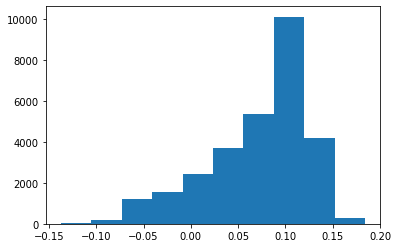

In [69]:
diff
plt.hist(diff)
plt.show()

In [76]:
details_test['res'] = preds

In [77]:
final = details_test.sort_values(['res'], ascending = False)
final.head(10)

,id,surname,name,rating,res
21619,36844,Щербина,Павел,855,0.951208
21625,51717,Джапаров,Ержан,2761,0.937103
21618,76264,Иваницкий,Илья,8125,0.934724
9513,224660,Байдуков,Валентин,0,0.932786
6696,108228,Резонтова,Наталья,286,0.932046
45348,32585,Улахович,Владимир,7590,0.923893
106480,73090,Третьяков,Кирилл,4675,0.919330
86969,169948,Павлов,Степан,75,0.915689
97218,201697,Бардин,Александр,1530,0.915094
4107,184250,Гудзь,Анна,1822,0.914087


результаты как-то не сильно вдохновили:)